In [1]:
%plot inline

In [2]:
!cat ../data/wines_classification/winequality.names

Citation Request:
  This dataset is public available for research. The details are described in [Cortez et al., 2009]. 
  Please include this citation if you plan to use this database:

  P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
  Modeling wine preferences by data mining from physicochemical properties.
  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

  Available at: [@Elsevier] http://dx.doi.org/10.1016/j.dss.2009.05.016
                [Pre-press (pdf)] http://www3.dsi.uminho.pt/pcortez/winequality09.pdf
                [bib] http://www3.dsi.uminho.pt/pcortez/dss09.bib

1. Title: Wine Quality 

2. Sources
   Created by: Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis (CVRVV) @ 2009
   
3. Past Usage:

  P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
  Modeling wine preferences by data mining from physicochemical properties.
  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 016

In [3]:
!head ../data/wines_classification/winequality-red.csv

"fixed acidity";"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"
7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5
7.8;0.88;0;2.6;0.098;25;67;0.9968;3.2;0.68;9.8;5
7.8;0.76;0.04;2.3;0.092;15;54;0.997;3.26;0.65;9.8;5
11.2;0.28;0.56;1.9;0.075;17;60;0.998;3.16;0.58;9.8;6
7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5
7.4;0.66;0;1.8;0.075;13;40;0.9978;3.51;0.56;9.4;5
7.9;0.6;0.06;1.6;0.069;15;59;0.9964;3.3;0.46;9.4;5
7.3;0.65;0;1.2;0.065;15;21;0.9946;3.39;0.47;10;7
7.8;0.58;0.02;2;0.073;9;18;0.9968;3.36;0.57;9.5;7


In [4]:
data = dlmread("../data/wines_classification/winequality-red.csv", ";" ,1, 0); % skip feature names
size(data)

ans =

   1599     12



# Preparing data

In [5]:
% randomize order of data for excluding biases in the dataset
n = rand(length(data),1);
[_ index] = sort(n);
data_rand = data(index, :);

In [6]:
data_norm = [];
mu = [];
sigma = [];

% normalizing data for optimum use of algorithms
for j = 1:11,
    mu = [mu; mean(data_rand(:,j))];
    sigma = [sigma; std(data_rand(:,j))];
    data_norm = [data_norm, (data_rand(:,j)- mu(j)*ones(size(data,1),1))/sigma(j)];
end
data_norm = [data_norm, data_rand(:,12)];

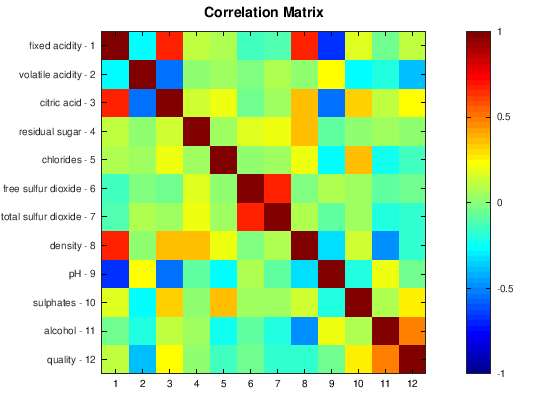

In [7]:
% correlation matrix
cor = corr(data_norm);

imagesc(cor);

set(gca, 'XTick', 1:size(cor,2)); % center x-axis ticks on bins
set(gca, 'YTick', 1:size(cor,2)); % center y-axis ticks on bins
set(gca, 'YTickLabel', ["fixed acidity - 1";"volatile acidity - 2";"citric acid - 3";"residual sugar - 4";
                        "chlorides - 5";"free sulfur dioxide - 6";"total sulfur dioxide - 7";"density - 8";
                        "pH - 9";"sulphates - 10";"alcohol - 11";"quality - 12"]); % set y-axis labels
                        
title('Correlation Matrix', 'FontSize', 14); % set title

caxis([-1, 1]);  % colorbar ranging from -1 to 1
colormap('jet'); % set the colorscheme
colorbar;        % enable colorbar

# Separating into training and testing set

In [8]:
X = data_norm(:,1:11); % inputs
y = data_norm(:, 12);  % labels

In [9]:
size(y)

ans =

   1599      1



In [10]:
% one-hot encode Y
Y = zeros([size(y, 1), 10]);

for i = 1:size(y, 1)
    Y(i, y(i)) = 1;
end

In [11]:
X_train = X(1:1119, :); % 70% for training
Y_train = y(1:1119, :);

X_test = X(1120:1599, :);  % 30% for testing
Y_test = y(1120:1599, :);

# ANN Architecture

In [12]:
% M number of labeled inputs
% N number of features (lenght of input vector)
[M, N] = size(X_train)

M =  1119
N =  11


In [13]:
O = 8 % number of neurons in the hidden layer
K = size(Y, 2) % number of classes

O =  8
K =  10


In [14]:
% initial weights matrix as small random values
W = randn([O N]).*0.01; % W: OxN
W_o = randn([K O]).*0.01;

In [15]:
% adding column for bias
X_train_bias = [ones(size(X_train,1),1), X_train]'; % X_train_bias: MxN+1
X_test_bias = [ones(size(X_test,1),1), X_test]';
W_bias = [ones(size(W,1),1), W]; % W_bias: N+1xO
W_o_bias = [ones(size(W_o,1),1), W_o];

# Learning

## Backpropagation


In [16]:
% generates F_prime OxO matrix
function F_prime = get_F_prime(u),
    F_prime = zeros(size(u,2), size(u,2));
    for i = 1:size(u,2),
        for j = 1:size(u,2),
            if i==j,
                F_prime(i,j) = (sech(u(1,i)))^2; % F: OxO
            end
        end
    end
end

In [17]:
function [W, MSE] = backprop_batch_step(X, S, W, W_o, alpha),

    [M, N] = size(X);
    O = size(W_o, 2) - 1;
    K = size(W_o, 1);

    E = [];
       
    update_W_o = zeros(size(W_o));
    update_W   = zeros(size(W));
    
    for i = 1:M,

        % feedfoward
        u = X(:,i)'*W';      % u: 1xO
        a = [1, tanh(u)];    % output of hidden layer a: 1x(O+1)
        Y = a*W_o';          % W_o': (O+1)xK, y: 1xK

        [_, Iw] = max(Y, [], 2);
        
        j = 1;
        for i = Iw,
            Y(j, :) = zeros([1, K]);
            Y(j, Iw) = 1;
            j = j + 1;
        end;
        
        Y;

        e = S(i,:) - Y; % e: 1xK
        E = [E; e];   % E: MxK
        
        
        delta_o = -2*e;        % dalta_o: 1xK
        
        F_prime = get_F_prime(u);      % F_prime: OxO
        Delta = -2*F_prime*W_o(:,2:O+1)'*e';     % Delta: OxO
        
        update_W_o = update_W_o + delta_o'*a;
        update_W   = update_W   + Delta*X(:,i)';        
    end
    
    W_o = W_o - alpha.*update_W_o;                              
    W = W - alpha.*update_W;

    % metric
    MSE = (sum(E,1)*sum(E,1)')/M;
end

In [18]:
function [W, mse_train_vec, mse_test_vec] = batch_backpropagation (X_te, X_tr, y_te, y_tr, W, W_o, alpha, epsilon, gamma,
                                                                    show_steps, max_iter),
    mse_test_vec = [];
    mse_train_vec = [];
    mse_test = epsilon+1;
    mse_min = inf;
    counter = 0;
    iter = 0;
    
    % stop if passed gamma steps without improvement 
    % or if error is less than epsilon
    % or if it is the iteration number max_iter
    while counter < gamma && mse_test > epsilon && iter < max_iter,
        mse_before = mse_test;
        mse_test = 0;
        [_, mse_test] = backprop_batch_step(X_te, y_te, W, W_o, alpha);
        mse_test_vec = [mse_test_vec; mse_test];
        [W, mse_train] = backprop_batch_step(X_tr, y_tr, W, W_o, alpha);
        mse_train_vec = [mse_train_vec; mse_train];
        
        if mse_test > mse_min,
            counter = counter + 1;
        else,
            mse_min = mse_test;
            counter = 0;
        end
        
        iter = iter + 1;
        
        if show_steps,
            iter
            [mse_train, mse_test]
        end
    end
    
    iter_min = iter - counter
    mse_min
    
end

In [19]:
# hyperparameters
epsilon = 0.1;
alpha = 1;
gamma = 50;
max_iter = 2000;

In [20]:
% backpropagation for number of hidden neurons as defined above in ANN architecture
[W_out, mse_train_vec, mse_test_vec] = batch_backpropagation(X_test_bias, ...
X_train_bias, Y_test, Y_train, W_bias, W_o_bias, alpha, epsilon, gamma, 0, max_iter);

iter_min =  1
mse_min =  4188


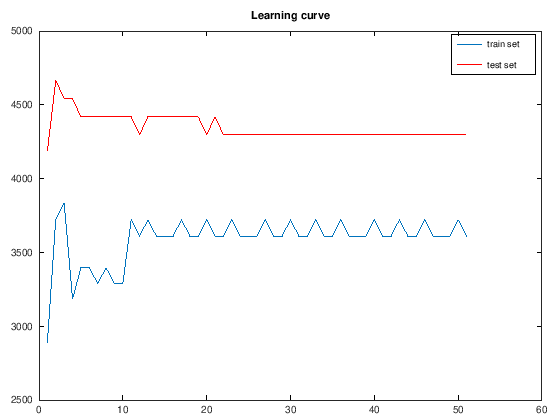

In [21]:
% learning curve
plot(mse_train_vec)
hold on
plot(mse_test_vec, 'r')
title('Learning curve')
legend('train set', 'test set')

neurons_hidden_layer =  10
alpha =  1
iter_min =  1
mse_min =  3952
neurons_hidden_layer =  10
alpha =  0.50000
iter_min =  2
mse_min =  3502.7
neurons_hidden_layer =  10
alpha =  0.10000
iter_min =  67
mse_min =  3393.5
neurons_hidden_layer =  10
alpha =  0.050000
iter_min =  14
mse_min =  3720.8
neurons_hidden_layer =  10
alpha =  0.010000
iter_min =  244
mse_min =  5314
neurons_hidden_layer =  10
alpha =  0.050000
iter_min =  24
mse_min =  2887.2
neurons_hidden_layer =  10
alpha =  0.0010000
iter_min =  59
mse_min =  3188.7
neurons_hidden_layer =  30
alpha =  1
iter_min =  7
mse_min =  5046
neurons_hidden_layer =  30
alpha =  0.50000
iter_min =  1
mse_min =  4188
neurons_hidden_layer =  30
alpha =  0.10000
iter_min =  27
mse_min =  3394
neurons_hidden_layer =  30
alpha =  0.050000
iter_min =  5
mse_min =  2892
neurons_hidden_layer =  30
alpha =  0.010000
iter_min =  15
mse_min =  2886.7
neurons_hidden_layer =  30
alpha =  0.050000
iter_min =  29
mse_min =  3835.3
neurons_hidden_laye

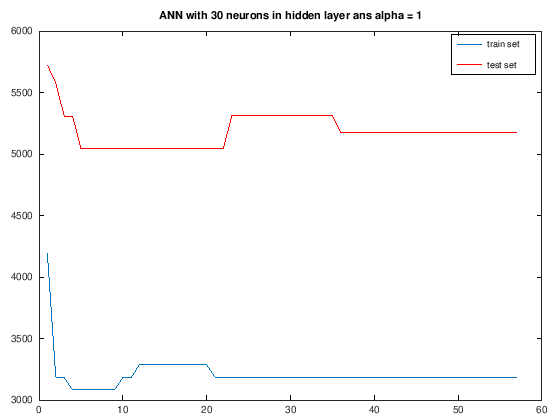

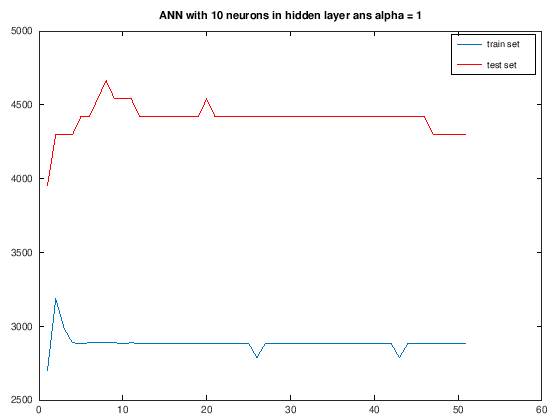

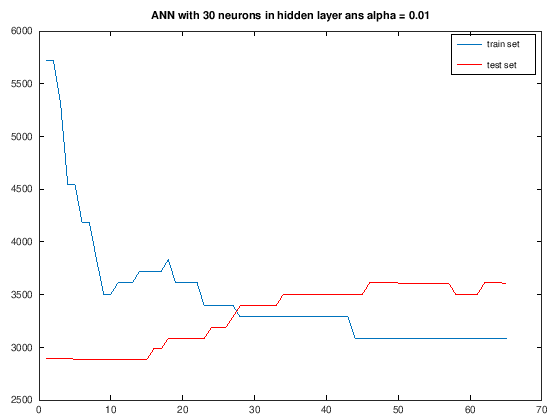

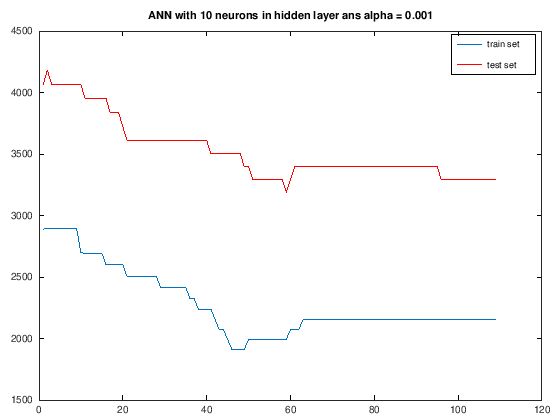

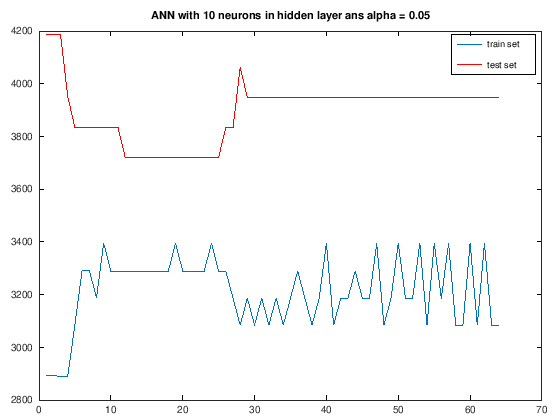

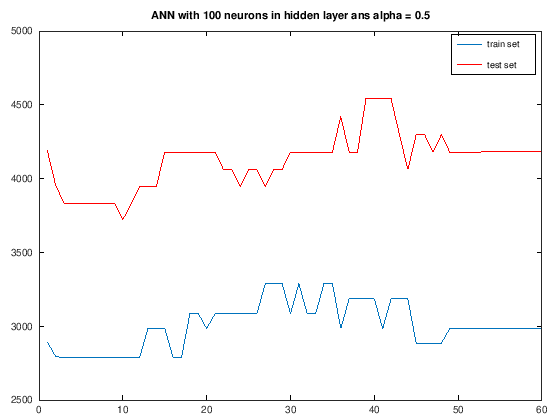

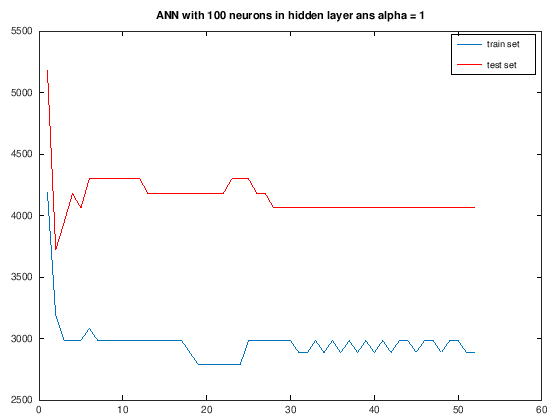

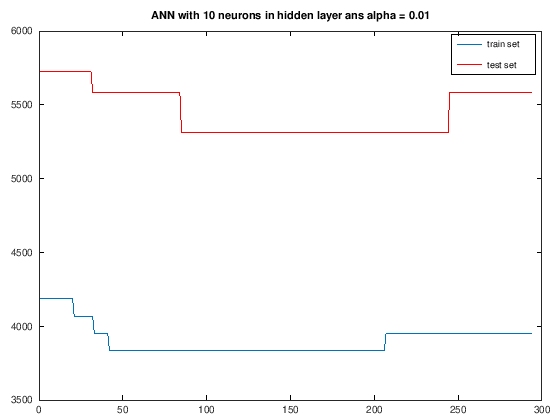

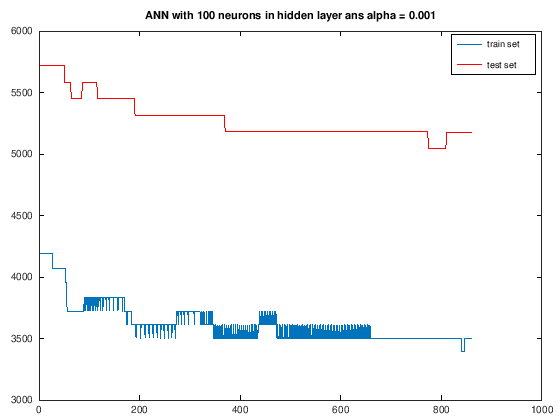

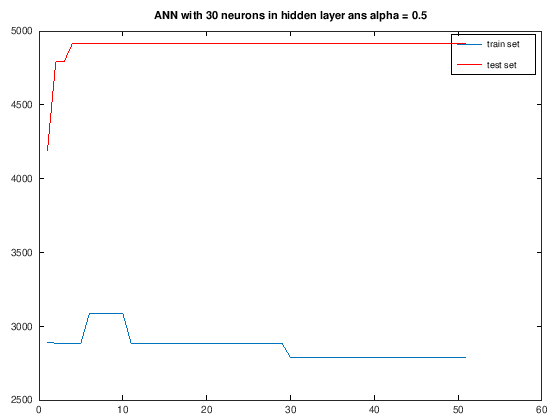

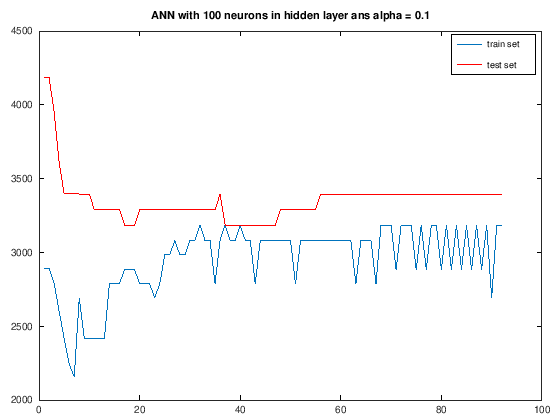

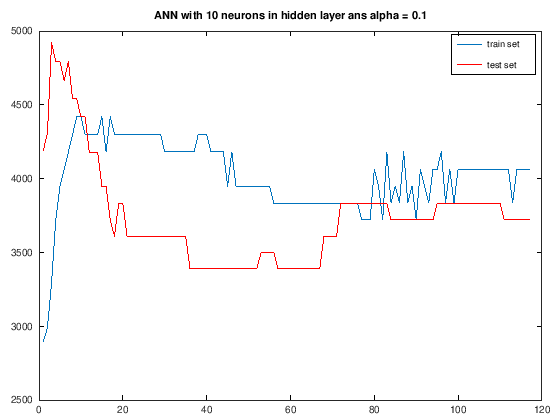

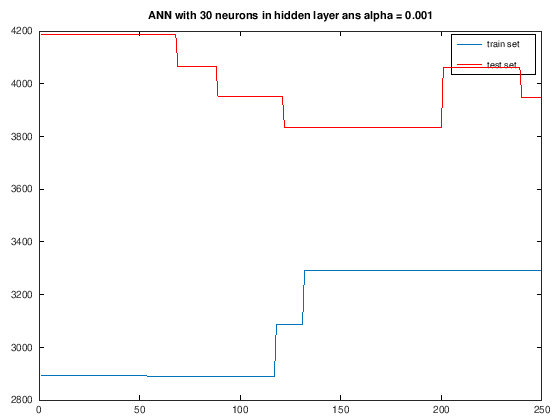

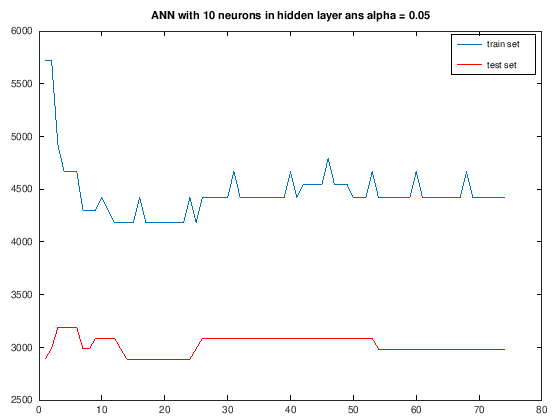

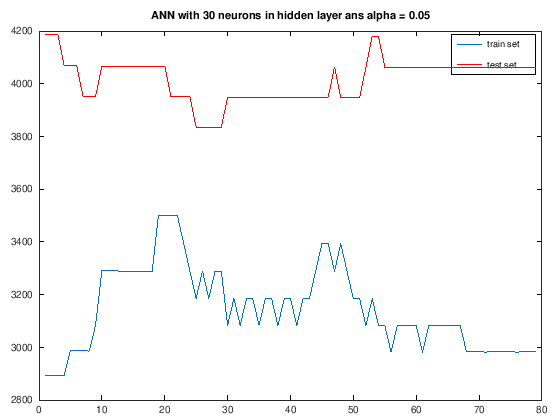

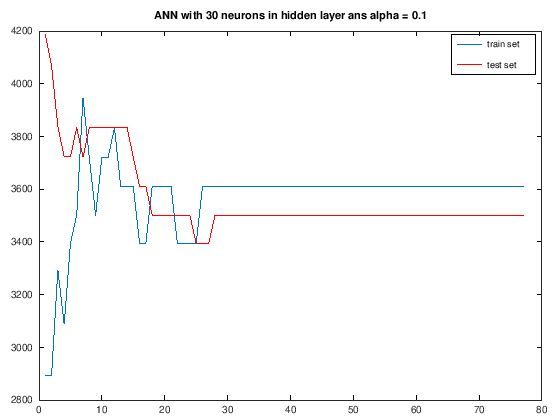

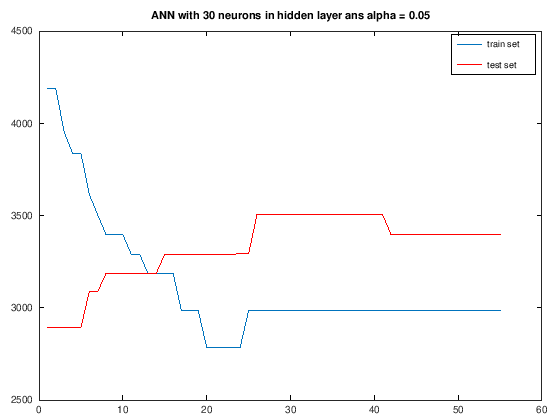

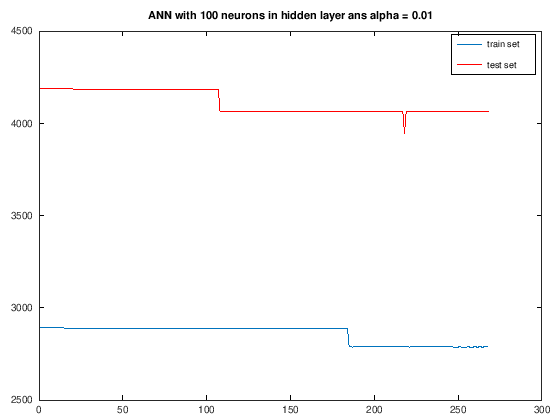

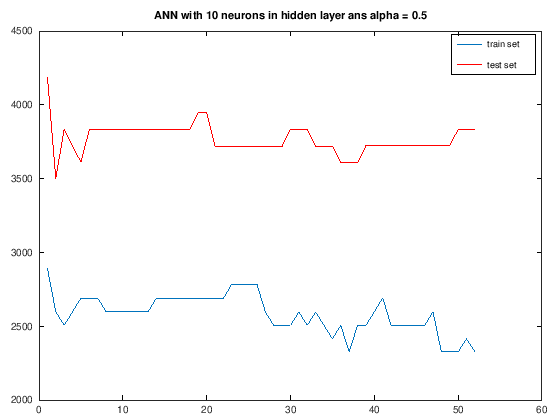

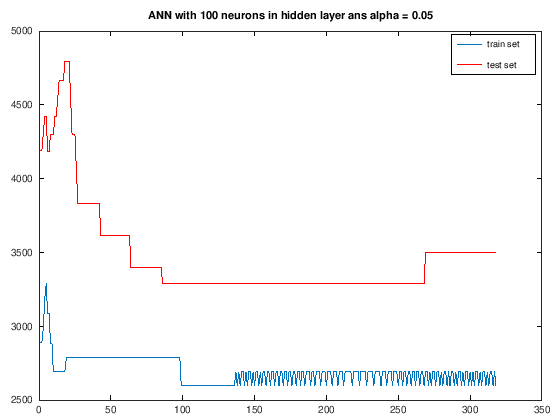

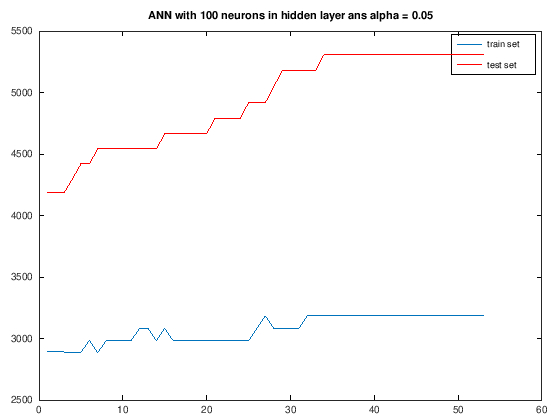

In [22]:
i = 1;
W_out = [];

% comparison of number of neurons in hidden layer
for O = [10, 30, 100],
    for alpha = [1 0.5 0.1 0.05 0.01 0.05 0.001],
    
        neurons_hidden_layer = O
        alpha

        W = randn([O N]).*0.01;
        W_to_store = zeros(size(W));
        W_bias = [ones(size(W,1),1), W];
        
        W_o = randn([K O]).*0.01;
        W_o_to_store = zeros(size(W_o));
        W_o_bias = [ones(size(W_o,1),1), W_o];

        [W_to_store, mse_train_vec, mse_test_vec] = ...
        batch_backpropagation(X_test_bias, X_train_bias, Y_test, Y_train, W_bias,
        W_o_bias, alpha, epsilon, gamma, 0, max_iter);
        W_out = [W_out; W_to_store];

        % learning curve
        figure(i)
        plot(mse_train_vec)
        hold on
        plot(mse_test_vec, 'r')
        title(['ANN with ' num2str(O) ' neurons in hidden layer ans alpha = ' num2str(alpha)])
        legend('train set', 'test set')

        i = i+1;
    end
end